# 动手学深度学习 章节12.5 多GPU训练

## 从零实现

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

创建LeNet

In [2]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])	# 卷积层, 20个3*3卷积核
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))	# 池化层
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])	# 卷积层, 50个5*5卷积核
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))	# 池化层
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]	# 全连接层, 800*128
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]	# 全连接层, 128*10
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

定义 `get_params` 函数, 将模型的参数复制到给定的device上

In [3]:
def get_params(params, device):
	new_params = [p.clone().to(device) for p in params]
	for p in new_params:
		p.requires_grad_()
	return new_params

In [4]:
new_params = get_params(params, torch.device('cuda:1'))
new_params

[tensor([[[[ 1.3089e-02, -3.8370e-03, -1.9307e-02],
           [ 8.6996e-03, -1.0970e-02,  4.0999e-03],
           [-1.2435e-03,  9.7574e-03, -1.6729e-02]]],
 
 
         [[[-1.3756e-02, -4.6522e-03,  2.7905e-03],
           [ 7.6903e-03, -1.2376e-02,  2.6903e-03],
           [ 5.7558e-03, -3.5537e-03,  1.2628e-03]]],
 
 
         [[[-3.6152e-03, -7.7638e-03,  3.5402e-03],
           [-8.7993e-04,  1.4372e-02,  1.7535e-02],
           [ 8.5510e-03,  1.4986e-02,  6.8587e-03]]],
 
 
         [[[-7.5068e-04, -1.9289e-03, -7.4780e-03],
           [-9.0746e-03, -1.3040e-02,  7.5636e-03],
           [-1.7565e-02, -8.2950e-03, -2.1145e-02]]],
 
 
         [[[ 2.7317e-03,  1.3943e-02,  1.9329e-04],
           [ 1.2996e-02,  1.5428e-02, -8.3152e-03],
           [-1.3151e-02, -5.8468e-04,  3.2250e-03]]],
 
 
         [[[ 2.5534e-06, -1.6768e-02, -5.2263e-03],
           [ 5.5018e-04, -1.6164e-02,  6.7479e-03],
           [-1.4261e-02, -1.9405e-03,  1.3161e-02]]],
 
 
         [[[ 7.2469e-03, -8.

定义 `allreduce` 函数,
将不同GPU上的张量在GPU0上汇总. 将汇总后的结果分发到不同的GPU上

In [5]:
def allreduce(data):
	"""
	data是一个列表, 列表中的每个元素是不同GPU上的数据
	"""
	for i in range(1, len(data)):
		data[0][:] += data[i].to(data[0].device)
	for i in range(1, len(data)):
		data[i][:] = data[0].to(data[i].device)

In [6]:
data = [torch.ones([1,2], device=d2l.try_gpu(i)) * (i+1) for i in range(2)]
print(data)

allreduce(data)
print(data)

[tensor([[1., 1.]], device='cuda:0'), tensor([[2., 2.]], device='cuda:1')]
[tensor([[3., 3.]], device='cuda:0'), tensor([[3., 3.]], device='cuda:1')]


定义 `split_batch` 函数,
将一份数据使用 `nn.parallel.scatter()` 拆分为多份, 送到不同的设备上

In [7]:
def split_batch(X:torch.Tensor, y:torch.Tensor, devices):
	"""
	Args:
		devices: 设备列表
	"""
	assert X.shape[0] == y.shape[0]
	return nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices)

训练一个batch的函数 `train_batch`

In [8]:
def train_batch(X, y, device_params, devices, lr):
	"""
	给定一个batch的数据, 将数据分片, 在不同的设备上过一遍
	最后聚合, 并反向传播

	Args:
		X: 一个batch的输入数据
		y: X所对应的标签
		device_params: 模型的参数列表
			列表中的每个元素都是一个完整的模型参数, 只不过是在不同的GPU上
		devices: 设备列表
		lr: 学习率
	"""
	X_shards, y_shards = split_batch(X, y, devices)
	ls = []
	# 分别计算每个GPU上的loss
	for X_shard, y_shard, device_param in zip(X_shards, y_shards, device_params):
		l = loss(lenet(X_shard, device_param), y_shard).sum()
		ls.append(l)
	# 每个GPU上单独反向传播
	for l in ls:
		l.backward()
	# 每个GPU的梯度相加, 并进行广播
	with torch.no_grad():
		# 模型的每一层的参数
		for i in range(len(device_params[0])):
			# 对相同层, 不同设备的参数的梯度进行allreduce
			allreduce([device_params[j][i].grad for j in range(len(device_params))])
	# 每个设备上单独梯度更新
	for param in device_params:
		d2l.sgd(param, lr, X.shape[0])

训练函数

与一般的训练函数唯一不同的地方就在于
1. `device_params = [get_params(params, d) for d in devices]`<br>一开始的时候将模型的参数分发到不同的设备上
2. `train_batch(X, y, device_params, devices, lr)`<br>使用之前定义的 `train_batch` 进行训练

In [9]:
from utils.data.mnist import load_data_fashion_mnist


def train(num_gpus, batch_size, lr):
    train_iter, test_iter = load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'	# type: ignore
          f'在{str(devices)}')

测试精度：0.84，2.3秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2)]


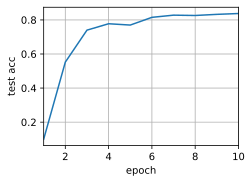

In [10]:
train(3, 256, 0.2)

重新初始化模型参数, 扩大batch_size和learning_rate再试一次

测试精度：0.80，1.7秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2)]


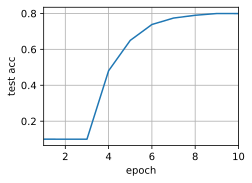

In [11]:
with torch.no_grad():
	scale = 0.01
	W1 = torch.randn(size=(20, 1, 3, 3)) * scale
	b1 = torch.zeros(20)
	W2 = torch.randn(size=(50, 20, 5, 5)) * scale
	b2 = torch.zeros(50)
	W3 = torch.randn(size=(800, 128)) * scale
	b3 = torch.zeros(128)
	W4 = torch.randn(size=(128, 10)) * scale
	b4 = torch.zeros(10)
	params = [W1, b1, W2, b2, W3, b3, W4, b4]


train(3, 256*3, 0.2*3)

## 简介实现

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

定义网络 `resnet`

In [12]:
class ResNet18(nn.Module):
	def __init__(self, num_classes, in_channels=1, *args, **kwargs) -> None:
		super().__init__(*args, **kwargs)
		self.net = nn.Sequential(
			nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
			nn.BatchNorm2d(64),
			nn.ReLU()
		)
		self.net.add_module("resnet_block1", self.resnet_block(64, 64, 2, first_block=True))
		self.net.add_module("resnet_block2", self.resnet_block(64, 128, 2))
		self.net.add_module("resnet_block3", self.resnet_block(128, 256, 2))
		self.net.add_module("resnet_block4", self.resnet_block(256, 512, 2))
		self.net.add_module("global_avg_pool", nn.AdaptiveAvgPool2d((1,1)))
		self.net.add_module("fc", nn.Sequential(nn.Flatten(), nn.Linear(512, num_classes)))
	

	def forward(self, X):
		return self.net(X)
	

	@staticmethod
	def resnet_block(in_channels, out_channels, num_residuals,
					 first_block=False):
		blk = []
		for i in range(num_residuals):
			if i == 0 and not first_block:
				blk.append(d2l.Residual(in_channels, out_channels,
										use_1x1conv=True, strides=2))
			else:
				blk.append(d2l.Residual(out_channels, out_channels))
		return nn.Sequential(*blk)

In [13]:
def train_concise(net, num_gpus, batch_size, lr):
	"""
	多GPU训练函数
	
	Args:
		net: 网络
		num_gpus: GPU数量
		batch_size: 批量大小
		lr: 学习率
	"""
	train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
	devices = [torch.device(f'cuda:{i}') for i in range(num_gpus)]
	def init_weights(m):
		if type(m) in [nn.Linear, nn.Conv2d]:
			nn.init.normal_(m.weight, std=0.01)
	net.apply(init_weights)
	# *** 首先需要显式的将网络移动到GPU上, 否则网络在CPU上DataParallel会报错
	net = net.to(devices[0])
	# *** 使用DataParallel将模型复制到num_gpus个GPU, 接下来的所有行为Pytorch会自动完成
	net = nn.DataParallel(net, device_ids=devices)
	trainer = torch.optim.SGD(net.parameters(), lr)
	loss = nn.CrossEntropyLoss()
	timer, num_epochs = d2l.Timer(), 10
	animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
	for epoch in range(num_epochs):
		net.train()
		timer.start()
		for X, y in train_iter:
			trainer.zero_grad()
			X, y = X.to(devices[0]), y.to(devices[0])
			l = loss(net(X), y)
			l.backward()
			trainer.step()
		timer.stop()
		animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
	print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'	# type: ignore
		  f'在{str(devices)}')

测试精度：0.92，6.1秒/轮，在[device(type='cuda', index=0)]


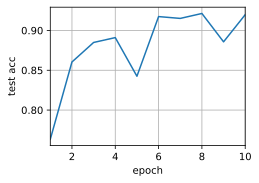

In [14]:
model = ResNet18(10)
train_concise(model, 1, 256, 0.1)

重置参数, 换个超参进行训练

In [15]:
def reinit_weights(m):
	if type(m) in [nn.Linear, nn.Conv2d]:
		nn.init.normal_(m.weight, std=0.01)
with torch.no_grad():
	model.apply(reinit_weights)

测试精度：0.83，7.7秒/轮，在[device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2)]


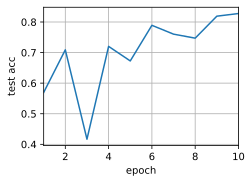

In [16]:
train_concise(model, 3, 256*3, 0.1*3)